# Load Simulated Patient Data

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import re
import pickle

In [13]:
from src.generate_simulated_data import load_patients_and_samples, load_patient_pkl_fn

# Load simulated data through a table

The table is organized to be compatible with the [CancerPatientReviewer](https://github.com/getzlab/CancerPatientReviewer)

In [128]:
samples, patients = load_patients_and_samples(
    path_to_sim_data='sim_data', 
    patient_names=None
)

/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/phylogicNDT_results_1000
loading existing CNV pickle file sim_data/patient1/patient1.cnv_events.pkl
sim_data/patient1/sample_coverage/p1_t1.binned_coverage.tsv already exists.
sim_data/patient1/sample_coverage/p1_t2.binned_coverage.tsv already exists.
sim_data/patient1/sample_coverage/p1_t3.binned_coverage.tsv already exists.
patient variants path exists: sim_data/patient1/patient1.variants.tsv
Sample p1_t1 has variants_fn: sim_data/patient1/sample_muts/p1_t1.variants.tsv
Sample p1_t2 has variants_fn: sim_data/patient1/sample_muts/p1_t2.variants.tsv
Sample p1_t3 has variants_fn: sim_data/patient1/sample_muts/p1_t3.variants.tsv
Run sim_data/patient1/sample_mut_vcf/p1_t1.variants.vcf through (nexus-snp hg19 RefSeq).
Generated sif file: sim_data/patient1/patient1.phylogicNDT.sif
Phylogic results are already loaded here: sim_data/patient1/phylogicNDT_results_1000
Not running commands. Outputs in sim_data/patient1/sample_ABSOL

In [129]:
patients

,maf_fn,cluster_ccfs_fn,build_tree_posterior_fn,tumor_molecular_subtype,tumor_morphology,tumor_primary_site,cancer_stage,vital_status,death_date_dfd,follow_up_date,age_at_diagnosis,gender,notes,treatments_fn
participant_id,,,,,,,,,,,,,,
patient1,sim_data/patient1/phylogicNDT_results_1000/pat...,sim_data/patient1/phylogicNDT_results_1000/pat...,sim_data/patient1/phylogicNDT_results_1000/pat...,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,sim_data/patient1/patient1_treatments.txt
patient2,sim_data/patient2/phylogicNDT_results_1000/pat...,sim_data/patient2/phylogicNDT_results_1000/pat...,sim_data/patient2/phylogicNDT_results_1000/pat...,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,sim_data/patient2/patient2_treatments.txt


# Load Patient objects

To directly access other intermediate files

In [452]:
path_to_sim_data = 'sim_data'
patient_names = ['patient1', 'patient2'] # or pass in list of patients from patients_pkl_fn
loaded_patients = [
    load_patient_pkl_fn(f'{path_to_sim_data}/{patient_name}/{patient_name}.pkl', path_to_sim_data, 'refseq_SimulatedTumor_{}.txt') for patient_name in patient_names
]

/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/phylogicNDT_results_1000
loading existing CNV pickle file sim_data/patient1/patient1.cnv_events.pkl
sim_data/patient1/sample_coverage/p1_t1.binned_coverage.tsv already exists.
sim_data/patient1/sample_coverage/p1_t2.binned_coverage.tsv already exists.
sim_data/patient1/sample_coverage/p1_t3.binned_coverage.tsv already exists.
patient variants path exists: sim_data/patient1/patient1.variants.tsv
Sample p1_t1 has variants_fn: sim_data/patient1/sample_muts/p1_t1.variants.tsv
Sample p1_t2 has variants_fn: sim_data/patient1/sample_muts/p1_t2.variants.tsv
Sample p1_t3 has variants_fn: sim_data/patient1/sample_muts/p1_t3.variants.tsv
Run sim_data/patient1/sample_mut_vcf/p1_t1.variants.vcf through (nexus-snp hg19 RefSeq).
Generated sif file: sim_data/patient1/patient1.phylogicNDT.sif
Phylogic results are already loaded here: sim_data/patient1/phylogicNDT_results_1000
Not running commands. Outputs in sim_data/patient1/sample_ABSOL

# Plotting functions

In [453]:
from cnv_suite.visualize import add_background
from cnv_suite import visualize
def plot_cn_profile(sample, absolute=True, interactive=False, **kwargs):

    seg_df = sample.absolute_cnv_profile_df.copy() if absolute else sample.acr_cnv_profile_df.copy()

    if interactive:
        fig, seg_df, trace_num, trace_end = visualize.plot_cnv_profile.plot_acr_interactive(
            seg_df, 
            sample.cnv_profile.csize, 
            purity=self.purity, ploidy=self.ploidy,
            segment_colors='difference', 
            **kwargs
            # sigmas=True, 
            # min_seg_lw=0.015, 
            # y_upper_lim=3
        )
        fig.update_layout(
            autosize=False,
            width=1000,
            height=500
        )
        fig.show()
    else:
        fig, ax = plt.subplots(1,1, figsize=(10, 4))
        fig = visualize.plot_cnv_profile.plot_acr_static(
            seg_df, 
            ax, sample.cnv_profile.csize, #cnv_profile.csize, 
            segment_colors='difference', 
            **kwargs
            # sigmas=True, 
            # min_seg_lw=3, 
            # y_upper_lim=3
        )

In [454]:
import seaborn as sns
import matplotlib.pyplot as plt
from AnnoMate.AppComponents.utils import cluster_color
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [455]:
def plot_ccf_and_muts(patient, output_dir=None, cluster_conversion=None, custom_palette=None):
    df = pd.read_csv(patients.loc[patient.name]['maf_fn'], sep='\t')
    df['original_cluster'] = df.apply(
        lambda r: patient.samples[0].annot_variants_df.query(
            f"Hugo_Symbol == '{r.Hugo_Symbol}' and Start_position == {r.Start_position}"
        )['cluster'].iloc[0], 
        axis=1
    )
    
    df['original_cluster_str'] = df['original_cluster'].replace(cluster_conversion)
    
    plt.figure(figsize=(7,5))

    if custom_palette is None:
        palette = {i: cluster_color(i) for i in df['original_cluster_str'].unique()}
    else:
        palette = {v: '#{:02X}{:02X}{:02X}'.format(*custom_palette[v]) for k, v in cluster_conversion.items()}

    palette_keys = list(palette.keys())
    palette_keys.sort()
    palette = {i: palette[i] for i in palette_keys}
    
    ax = sns.lineplot(
        df, x='Sample_ID', y='preDP_ccf_mean', 
        hue='original_cluster_str', units="Hugo_Symbol", estimator=None,
        palette=palette,
        alpha=0.3, lw=1, linestyle='dotted'
    )
    ax.legend_.remove()

    reformat_ccfs_df = patient.sample_ccfs_df.stack().reset_index().rename(
        columns={'level_0': 'Sample', 'level_1': 'Cluster', 0: 'Cancer Cell Fraction (CCF)'}
    )
    reformat_ccfs_df['Cluster'] = reformat_ccfs_df['Cluster'].replace(cluster_conversion)
        
    sns.lineplot(
        data=reformat_ccfs_df, 
        x='Sample', 
        y='Cancer Cell Fraction (CCF)', 
        hue='Cluster', 
        palette=palette,
    )
        
    plt.ylabel('Cancer Cell Fraction (CCF)', fontsize=15)
    plt.xlabel('Sample ID', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f'{patient.name} CCF plot', fontsize=20)

    # plt.tight_layout()

    linestyles = {'Clone': '-', 'Mutation': 'dotted'}
    cluster_legend = plt.legend(
        handles=[Line2D([0.5,1],[0.5,1], color=color, label=label, lw=4) for label, color in palette.items()] + 
            [Line2D([0.5,1],[0.5,1],linestyle=ls, color='k', label=label) for label, ls in linestyles.items()], 
        fontsize=15, title="Cluster", title_fontsize=20, bbox_to_anchor=(1.4, 1)
    )

    if output_dir:
        output_fn = f"{output_dir}/{patient.name}.plot_ccf_and_muts.svg"
        plt.savefig(output_fn, bbox_inches='tight')


In [484]:
# modified from https://github.com/getzlab/PhylogicNDT/blob/84d3dd2713ed989dbe038fee54fdd0cd564d1a45/output/PhylogicOutput.py#L465
def make_pie_plot(patient, sample_idx, palette, output_dir=None, cluster_conversion=None):
    """
    Makes clonal abundance pie plot
    Args:
        patient: patient object
        sample_idx: which sample from the patient
        output_dir: output directory to save svg
    
    Returns:
    """
    sample = patient.samples[sample_idx]
    
    parents = dict(patient.parents)
    cluster_abundances = dict(sample.clone_ccfs)

    if cluster_conversion:
        parents = {cluster_conversion[k]: cluster_conversion[v] for k, v in parents.items()}
        cluster_abundances = {cluster_conversion[k]: v for k, v in cluster_abundances.items()}

    tree = convert_tree(parents)
    
    plt.figure(figsize=(1, 1))
    ax = plt.gca()
    pie_slices = {}
    node_order = list(traverse_by_branch(tree, None))
    for level, clusters in enumerate(traverse_by_level(tree, root=None)):
        for node in clusters:
            if node is None:
                continue
            pie_slices[node] = cluster_abundances[node]
            if parents[node]:
                pie_slices[parents[node]] -= cluster_abundances[node]
        x = []
        colors = []
        for node in node_order:
            if node in pie_slices:
                x.append(pie_slices[node])
                colors.append(palette[node])
        ax.pie(x, colors=colors, radius=.9-(.1*level))
    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_title(sample.name)

    if output_dir:
        output_fn = f'{output_dir}/{patient.name}.{sample.name}.make_pie_plot.svg'
        plt.savefig(output_fn, bbox_inches='tight', pad_inches=0., transparent=True)
        return output_fn

def convert_tree(clone_tree):
    parent_child_tree = {}
    for child, parent in clone_tree.items():
        if parent not in parent_child_tree.keys():
            parent_child_tree[parent] = [child]
        else:
            parent_child_tree[parent].append(child)

    return parent_child_tree
    
# helper functions https://github.com/getzlab/PhylogicNDT/blob/84d3dd2713ed989dbe038fee54fdd0cd564d1a45/BuildTree/Tree.py
def traverse_by_branch(tree, parent):
    try:
        children = tree[parent]
    except KeyError:
        children = []
    yield parent

    for child in children:
        for c in traverse_by_branch(tree, parent=child):
            yield c

def traverse_by_level(tree, root=None):
    next_level = [root]
    while next_level:
        yield next_level
        next_level = sum(([c for c in tree[child]] for child in next_level if child in tree.keys()), [])
        

In [457]:
import os
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

# Plot patient1

In [458]:
patient1 = loaded_patients[0]

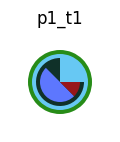

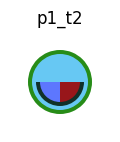

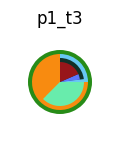

In [485]:
for i, _ in enumerate(patient1.samples):
    make_pie_plot(
        patient1, i, 
        palette={i: cluster_color(i) for i in list(patient1.parents.keys())},
        output_dir=plots_dir
    )
    plt.show()

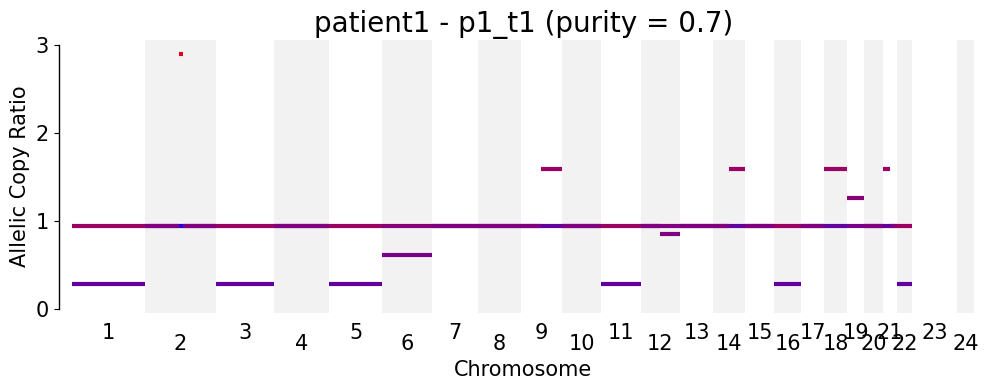

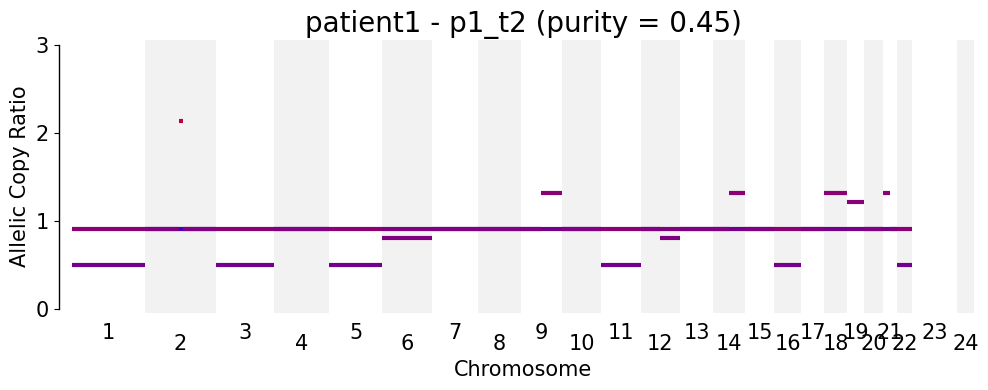

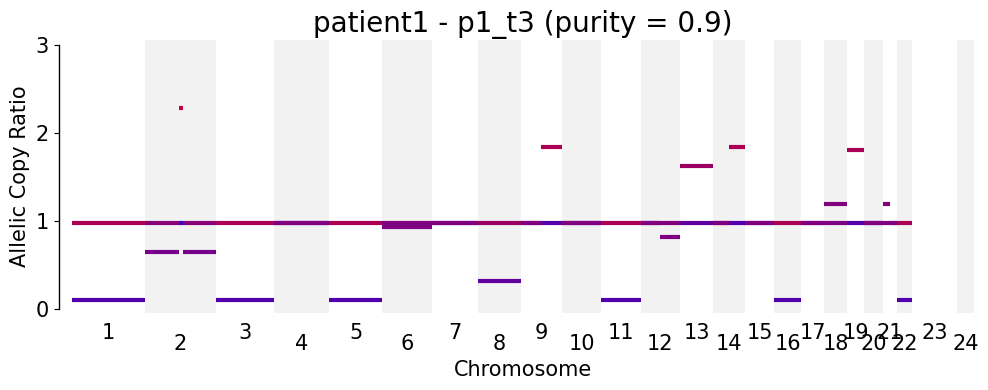

In [489]:
for sample in patient1.samples:
    plot_cn_profile(
        sample, absolute=False, interactive=False,
        sigmas=False, 
        min_seg_lw=3, 
        y_upper_lim=3
    )
    plt.ylabel("Allelic Copy Ratio", fontsize=15)
    plt.xlabel("Chromosome", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{patient1.name} - {sample.name} (purity = {sample.purity})", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/{sample.name}.cn_profile.svg")

In [462]:
patient1.plot_tree(port=8051)

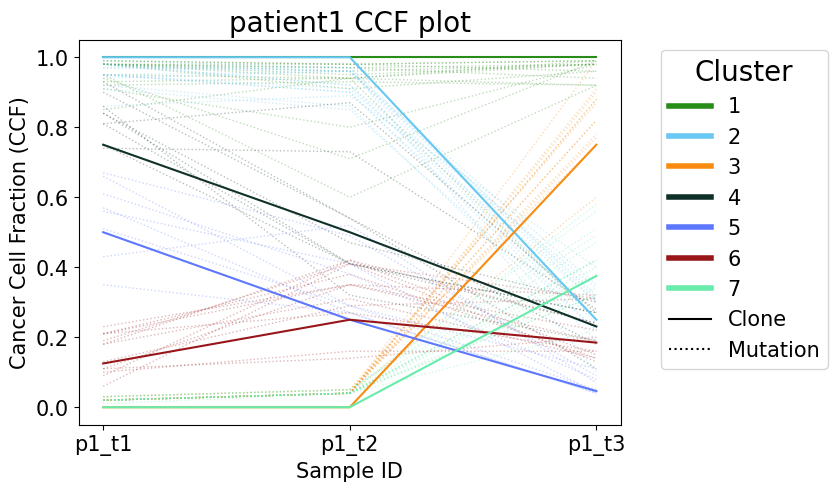

In [463]:
plot_ccf_and_muts(patient1, plots_dir)

In [464]:
patient1.variants_df['cluster'].value_counts()

7    16
1    16
2    16
6    16
3    15
4    11
5    11
Name: cluster, dtype: int64

# Patient2

In [465]:
patient2 = loaded_patients[1]

In [466]:
patient2.plot_tree(port=8051)

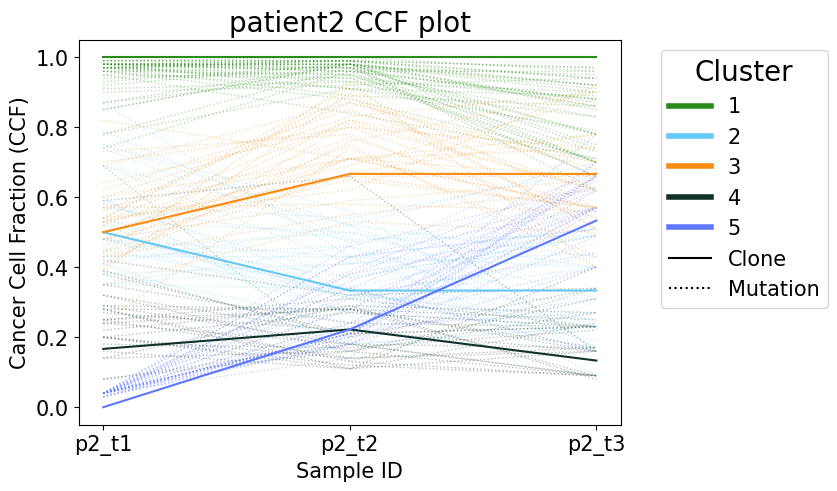

In [467]:
plot_ccf_and_muts(patient2)

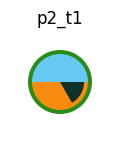

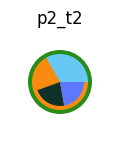

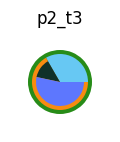

In [486]:
for i, _ in enumerate(patient2.samples):
    make_pie_plot(
        patient2, i, 
        palette={i: cluster_color(i) for i in list(patient1.parents.keys())},
        output_dir=plots_dir
    )
    plt.show()

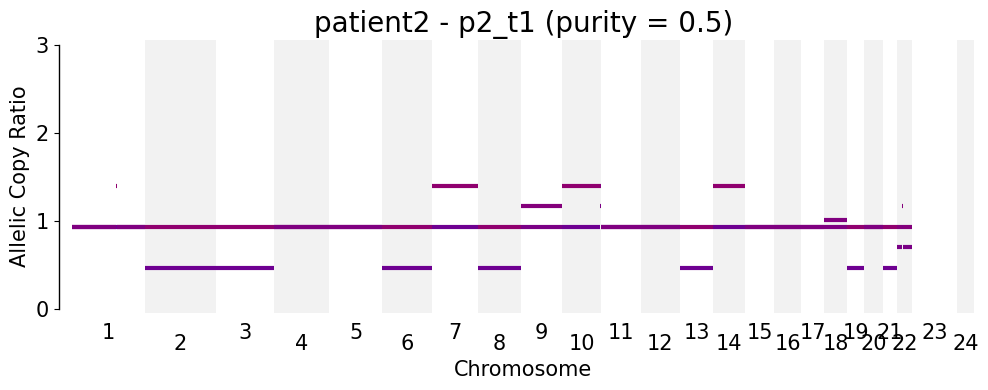

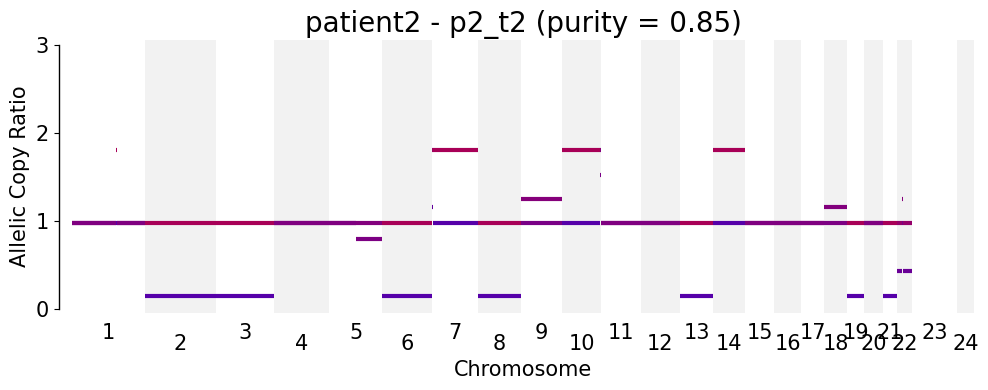

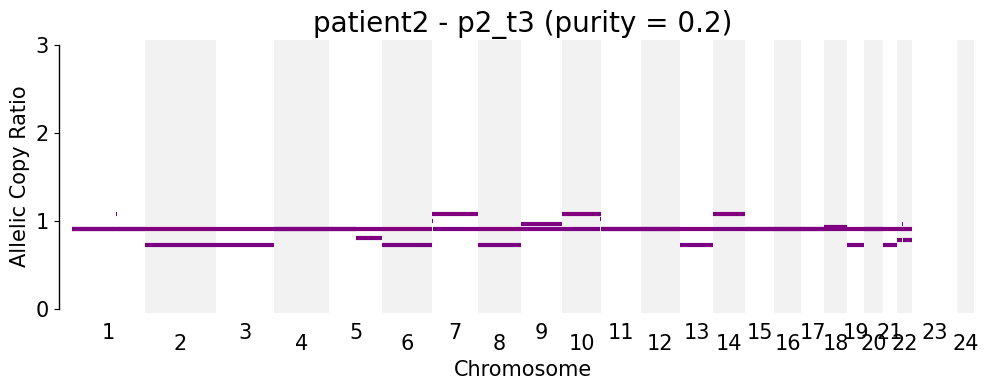

In [488]:
for sample in patient2.samples:
    plot_cn_profile(
        sample, absolute=False, interactive=False,
        sigmas=False, 
        min_seg_lw=3, 
        y_upper_lim=3
    )
    plt.ylabel("Allelic Copy Ratio", fontsize=15)
    plt.xlabel("Chromosome", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{patient2.name} - {sample.name} (purity = {sample.purity})", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/{sample.name}.cn_profile.svg")

## For purposes of the supplemental figures, clusters are renamed

In [470]:
cluster_conversion = {1:1, 2:3, 3:2, 4:5, 5:4, 6:6, 7:7, None:None}

In [471]:
import copy
copy_patient2 = copy.deepcopy(patient2)

In [472]:
copy_patient2.parents = {cluster_conversion[k]: cluster_conversion[v] for k, v in patient2.parents.items()}

In [473]:
copy_patient2.variants_df['cluster'].value_counts().rename(index=cluster_conversion)

1    48
3    42
2    38
5    38
4    35
Name: cluster, dtype: int64

In [474]:
copy_patient2.plot_tree()

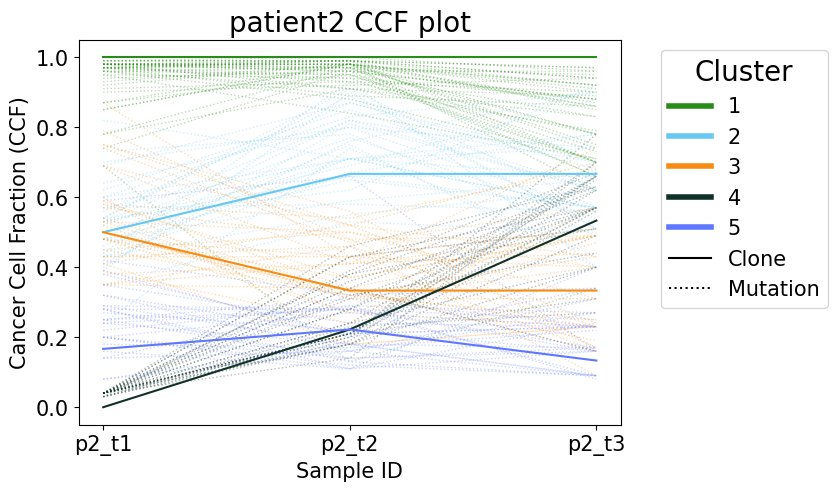

In [475]:
plot_ccf_and_muts(patient2, plots_dir, cluster_conversion=cluster_conversion)

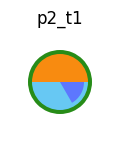

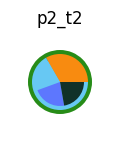

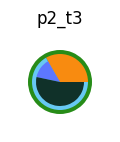

In [487]:
for i, _ in enumerate(patient2.samples):
    make_pie_plot(
        patient2, i, 
        palette={i: cluster_color(i) for i in list(patient1.parents.keys())},
        output_dir=plots_dir,
        cluster_conversion=cluster_conversion
    )
    plt.show()